# Проект по определению стоимости старых автомобилей
### Описание конечных точек

## 1
- **Корень проекта, приветствие**

        @app.get('/')
        def description():
            return "Hello, it's about Machine Learning"
        
        
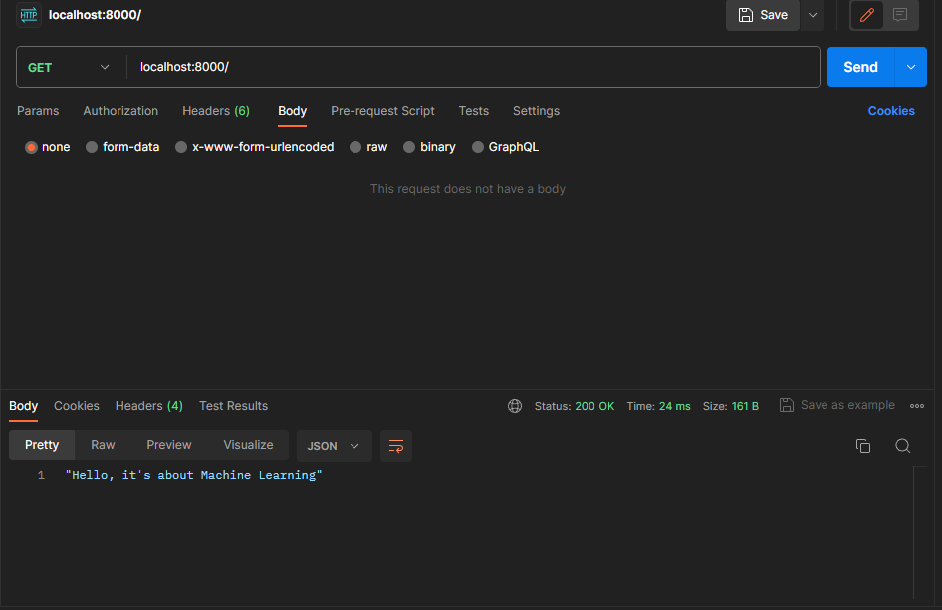

## 2
- **Описание проекта**

        @app.get('/project_info')
        def description_company():
            return {
                "message": "Our company is engaged in determining the price of old cars "
                           "according to the following parameters fuel type: gas or diesel, "
                           "number of cylinders, number of doors, power(horsepower)"}


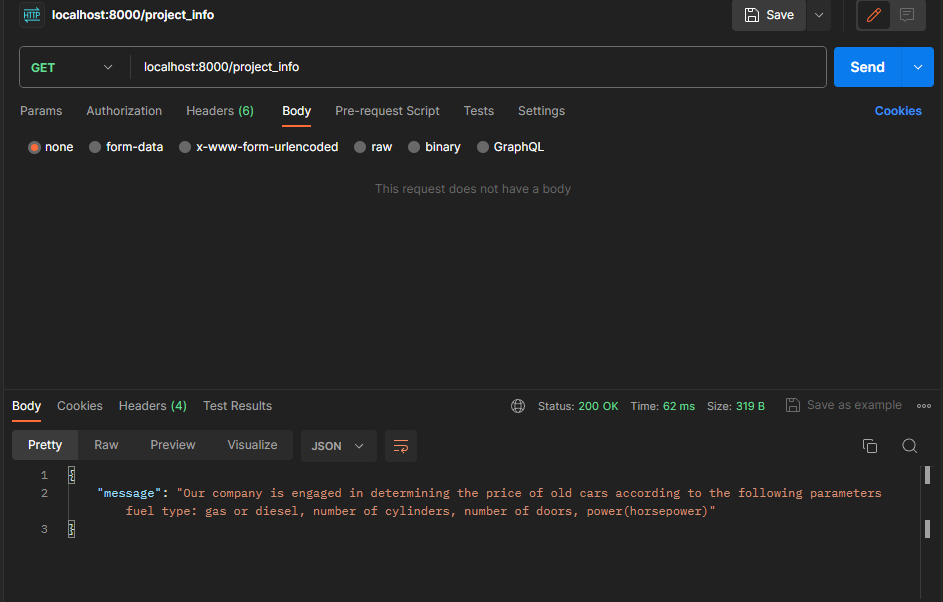

## 3

- **Зарегистрировать пользователя:**
- В схемах(shemas_pd) находится класс UserReg, который наследуется от pydantic BaseModel, сделано для того чтобы валидировать типы входных данных, далее добавляем пользователя в базу данных

        @app.post("/user/add", response_model=UserReg)
        def add_user(user: UserReg, db: Session = Depends(get_db)):
            user = User(name=user.name,
                        surname=user.surname,
                        location=user.location)
            db.add(user)
            db.commit()
            return user
            
- **У нас есть пользователи в базе данных, которых мы добавили попробуем добавить еще одного**

            {"name": "Иван",
            "surname": "Иванов",
            "location": "Санк-Петербург"}
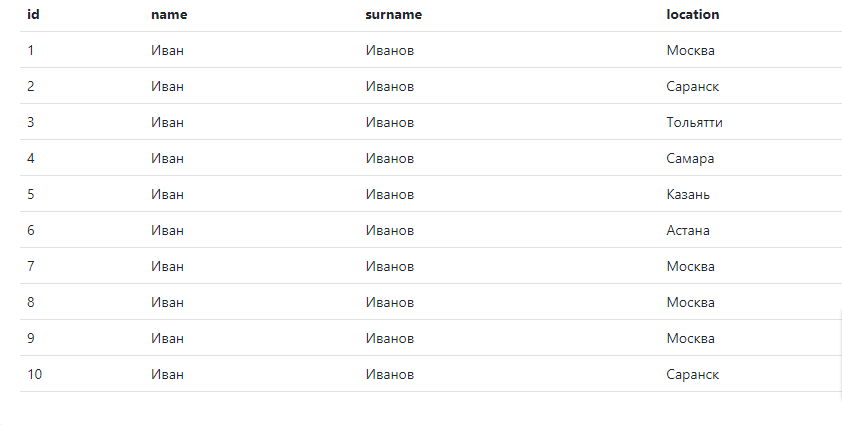

- **Status code: 200, говорит о том что все прошло успешно**
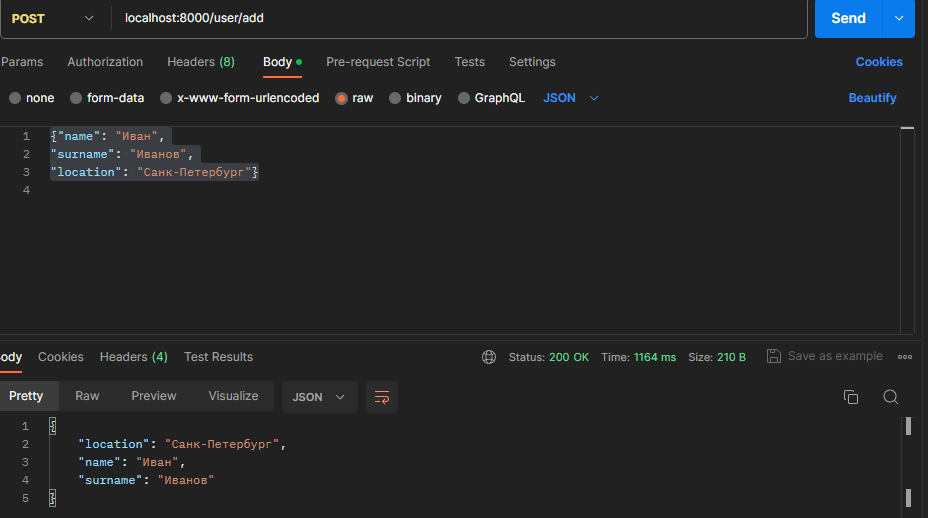

- **Проверим**
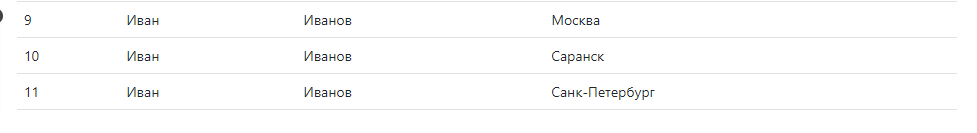

- **Теперь попробуем другого пользователя**

        {"name": 12345,
        "surname": "Иванов",
        "location": "Санк-Петербург"}

- **Ожидаемо получили ошибку, но сработает вариант передачи в виде строки "12345"**
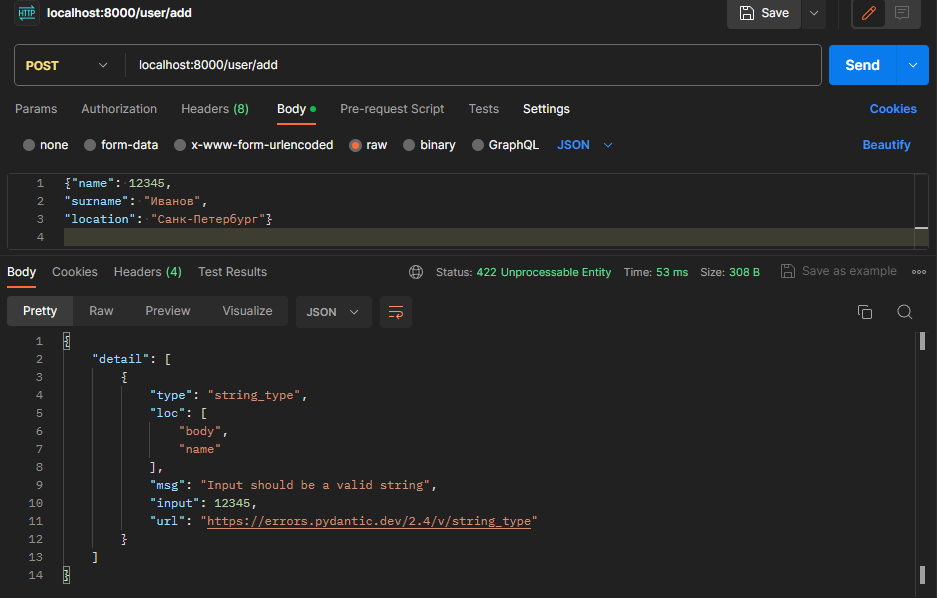


## 4
- **Добавить машину**
- **У нас есть пользователи, теперь сделаем возможность чтобы они добавляли себе автомобили**
- **Так же будем поднимать исключение в случае если пользователь не зарегестрирован и если введеный тип топлива не соответствует тем типам с которыми работает наша компания**

        @app.post("/car/add/{user_id}", response_model=CarReg)
        def add_car(user_id, car_data: CarReg, db: Session = Depends(get_db)):
            if not bool(db.query(User.id).filter(User.id == user_id).first()):
                raise HTTPException(404, detail='User not found')
        
            if car_data.fuel_type.lower() not in ('gas', 'diesel'):
                raise HTTPException(400, detail="Invalid fuel type")
        
            new_car = Car(fuel_type=car_data.fuel_type,
                         num_of_cylinders=car_data.num_of_doors,
                         num_of_doors=car_data.num_of_doors,
                         engine_power=car_data.engine_power,
                         price=car_data.price,
                         user_id=user_id)
            db.add(new_car)
            db.commit()
            return new_car

- **Посмотрим на пользователей которые уже добавили авто**
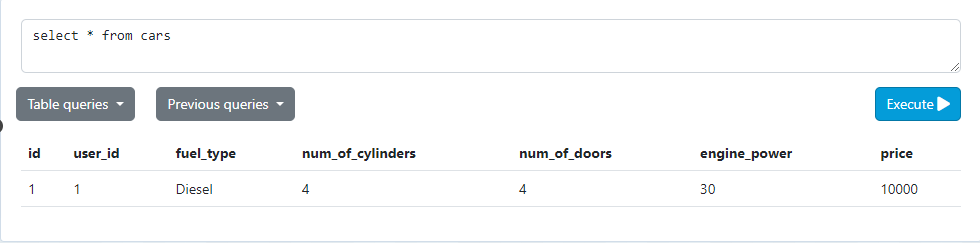

- **Добавим пользователю с id==1 еще одну машину, ведь у пользователя может быть несколько машин**
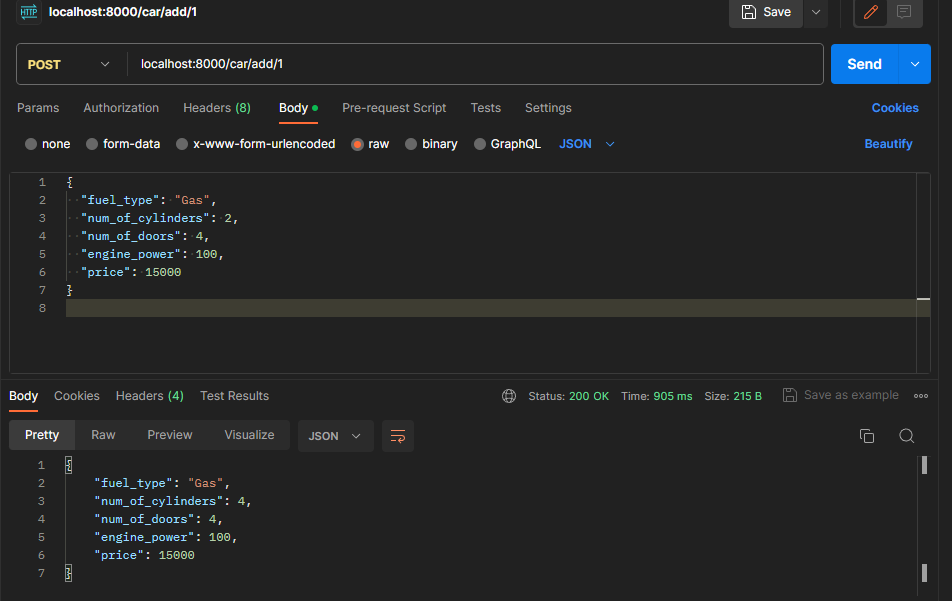

- **Проверим**
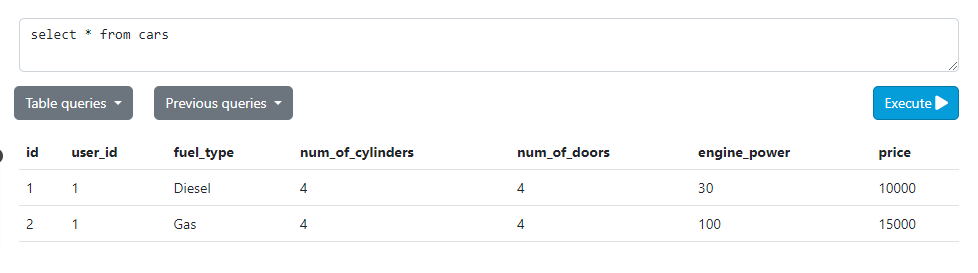

- **Так же для примера добавим другому пользователю, например с User.id==2 авто**
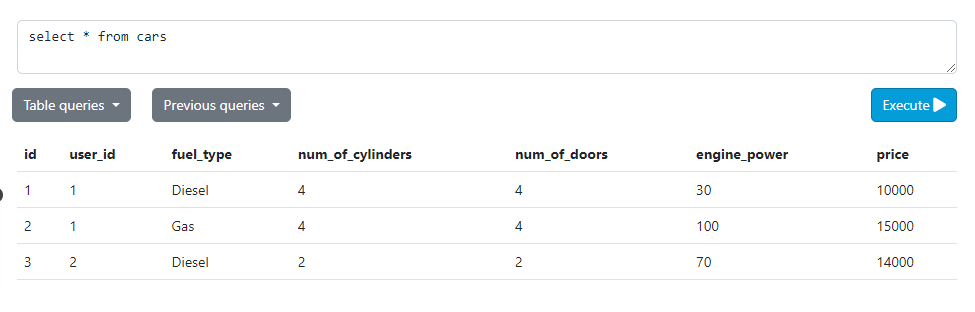

- **Попробуем ввести пользователя которого нет в базе данных, затем проверим неккоректный тип топлива**
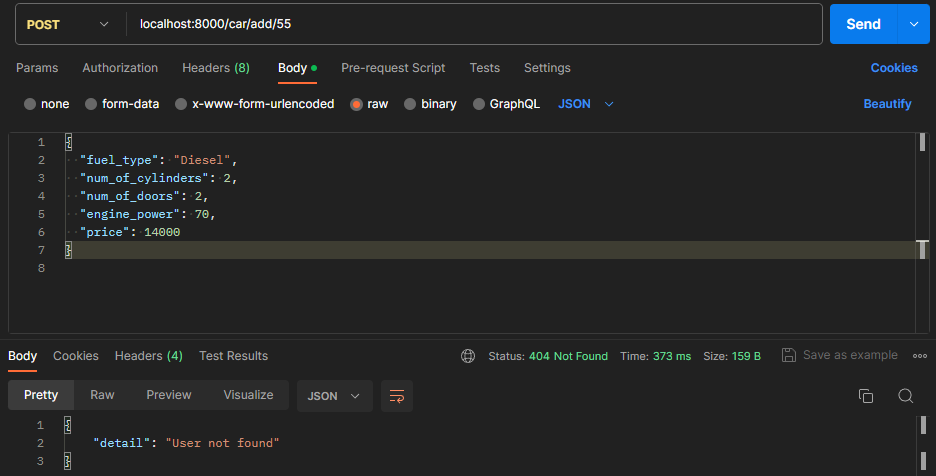

- **У нас точно есть пользователь с id==1, проверим тип топлива**
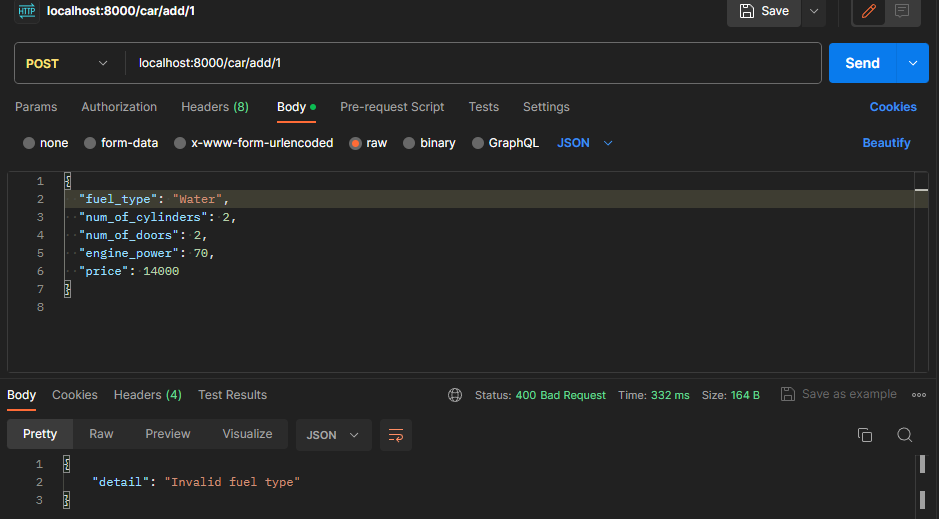

---

## 5
- **Вернуть по пользователю все его автомобили**
- **Валидировать ответ будем с помощью класса CarReg**

    @app.get('/user/cars/{user_id}', response_model=List[CarReg])
    def get_car(user_id: int, db: Session = Depends(get_db)):
        if not bool(db.query(Car.id).filter(Car.user_id == user_id).first()):
            raise HTTPException(404, detail='User not found')
    
        return db.query(Car.fuel_type,
                       Car.num_of_cylinders,
                       Car.num_of_doors,
                       Car.engine_power,
                       Car.price).filter(Car.user_id==user_id).all()
    

- **Действительно, у пользователя с id==1, 2 автомобиля на продажу**
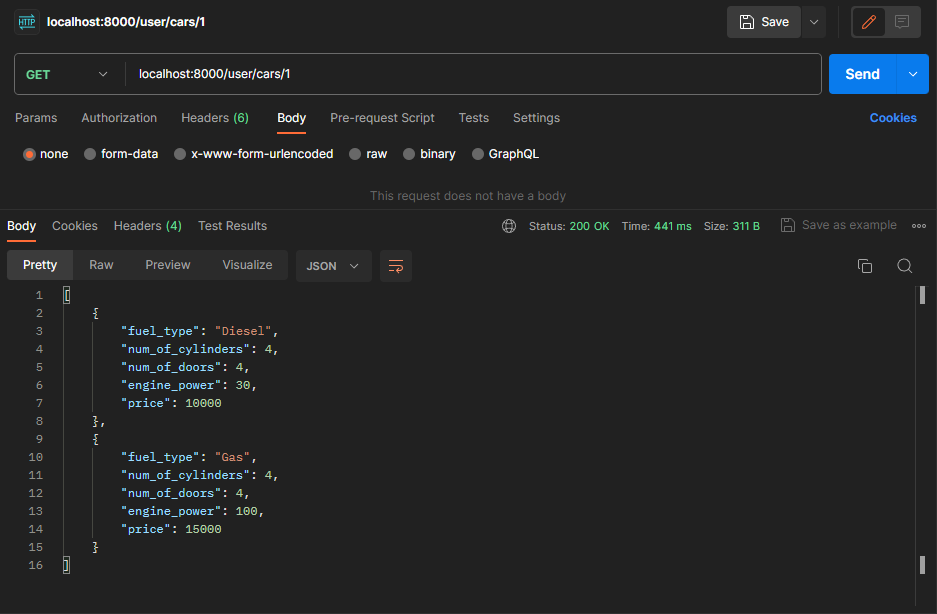

## 6
- **Получить всех пользователй, валидировать ответы будес с помощью класса UserCheck**

        @app.get("/user/all", response_model=List[UserCheck])
        def get_all_users(db: Session = Depends(get_db)):
            return db.query(User).all()
            
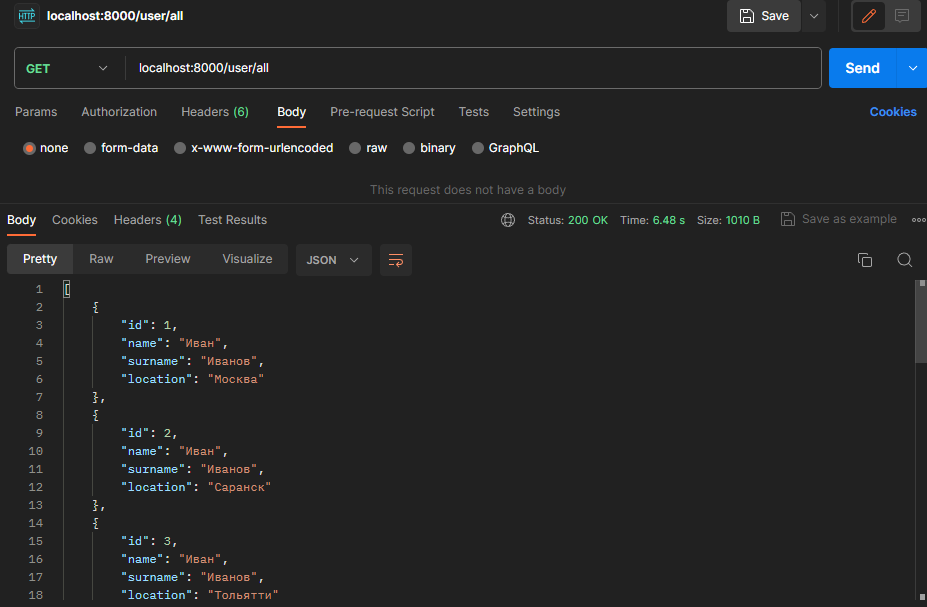

## 7
- **Получить реккомендованную цену, для этого раннее мы обучили случайный лес, так же поднимем исключение в случае неккоректного типа топлива**


        @app.get("/car/prediction/")
        def get_price(car: CarPrice, db: Session = Depends(get_db)):
            if car.fuel_type.lower() not in ('gas', 'diesel'):
                raise HTTPException(400, detail="Invalid fuel type")
        
            fuel_type = int(car.fuel_type.lower().replace('gas', '1').replace('diesel', '0'))
            num_of_cylinders = car.num_of_cylinders
            num_of_doors = car.num_of_doors
            engine_power = car.engine_power
            vector = [[fuel_type, num_of_cylinders,
                       num_of_doors, engine_power]]
            model = joblib.load('cars_app/rf_model_total.pkl')
            price = model.predict(vector)
            return {f'Reccommended price: {int(price[0])}'}
            

- **Проверим на исключение**
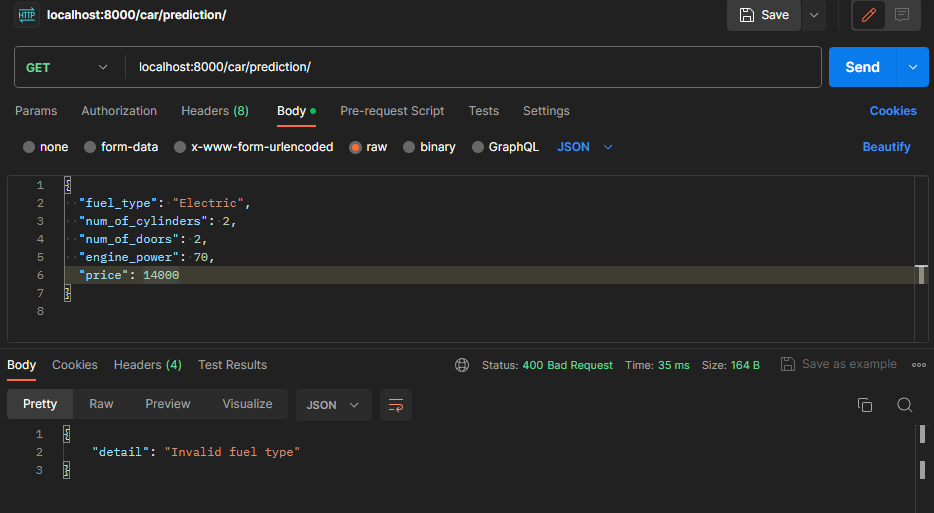

- **Теперь возьмем пользователя с id==1, его машину с типом diesel и попробуем узнать цену**
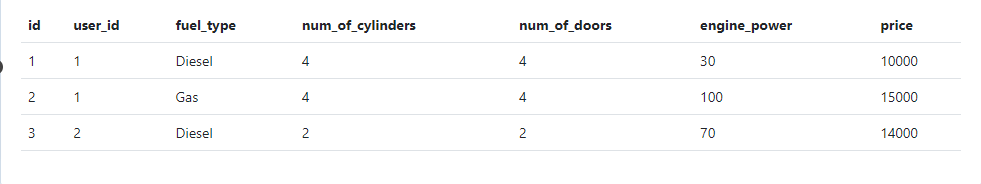

- **Получили цену в 8.241 рубль, цена пользователя 10.000**
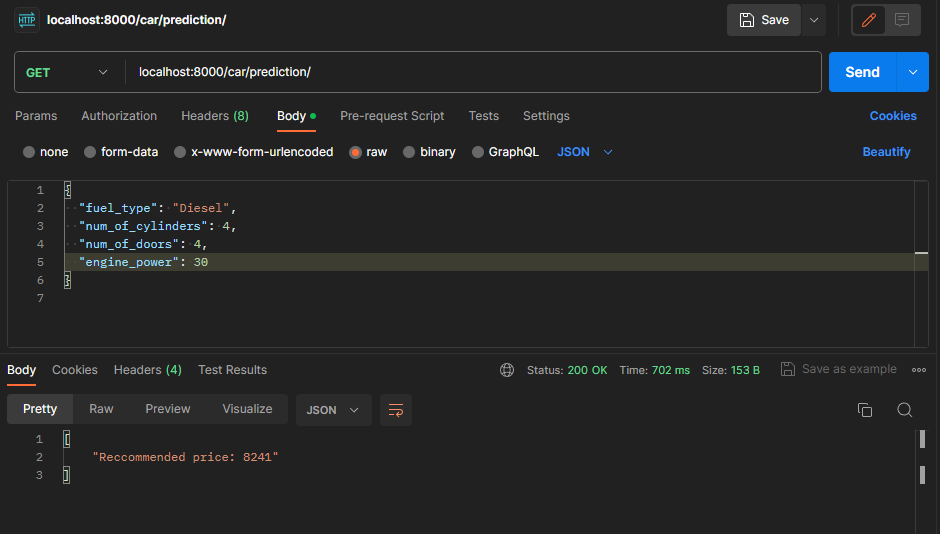

---

- **Попробуем для второго автомобиля, получили цену 12.864, цена пользователя 15.000**
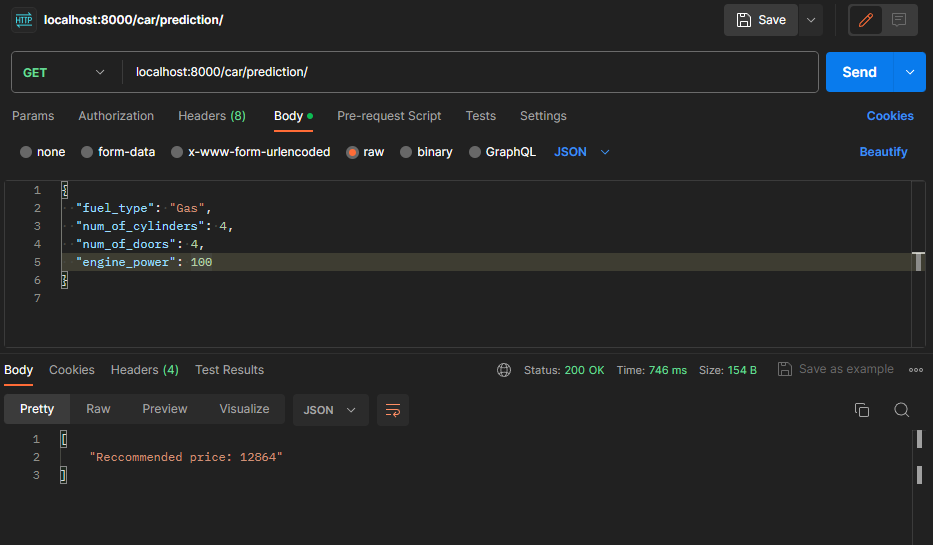

## 8 
- **Возможность для пользователя обновить цену на свой автомобиль**

        @app.get("/car/update_price/{user_id}/{car_id}/{new_price}")
        def update_price(user_id: int,
                         car_id: int,
                         new_price: int,
                         db: Session = Depends(get_db)):
            db.query(Car).filter(Car.id==car_id).filter(Car.user_id==user_id).update({Car.price: new_price},
                                                                                         synchronize_session = False)
            db.commit()
            return {f"Price update to {new_price}"}

- **Обновим цену для пользователя с Car.id==1, Car.user_id==1, на реккомендованную(8.241)**
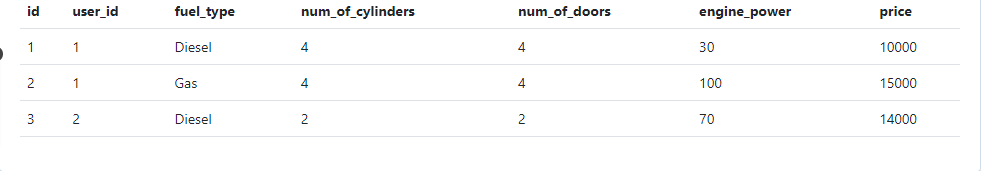
---

- **Все прошло успешно**
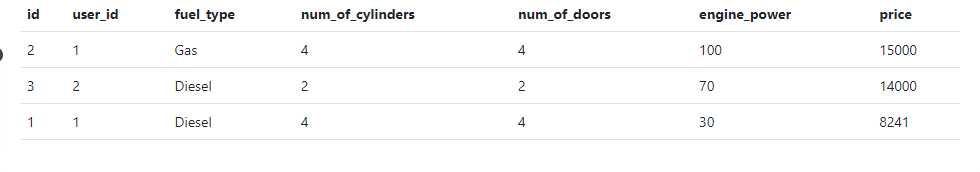

- **Обновим цену для для Car.user_id == 2, на реккомендованную(12.864)**
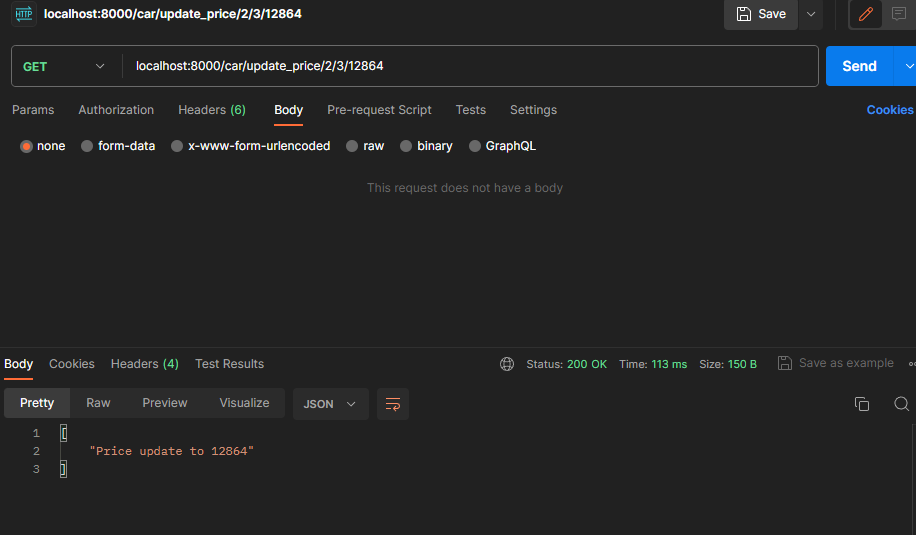

- **Все прошло успешно**
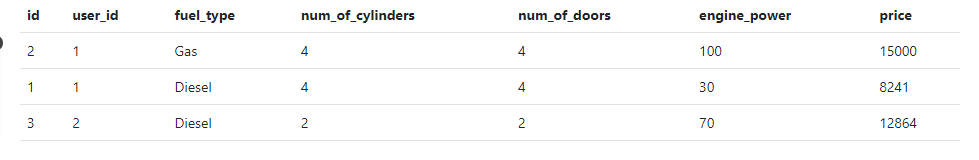

## Вывод:
- **Сделали следующие конечные точки**:

    - **@app.get('/') - `для приветствия`**
    
    - **@app.get('/project_info') - `для описания деятельности компании`**

    - **@app.post("/user/add", response_model=UserReg) - `добавить пользователя в приложение чтобы потом он мог создать объявление о машине и выставить ее на продажу`**

    - **@app.post("/car/add/{user_id}", response_model=CarReg) - `добавить автомобиль для каждого пользователя`**

    - **@app.get('/user/cars/{user_id}', response_model=List[CarReg]) - `по id пользователя получить все автомобили пользователя выставленные на продажу`**

    - **@app.get("/user/all", response_model=List[UserCheck]) - `посмотреть всех пользователей которые зарегистрированы`**

    - **@app.get("/car/prediction/") - `получить реккомендованную цену на свой автомобиль`**

    - **@app.get("/car/update_price/{user_id}/{car_id}/{new_price}") - `обновить цену своего автомобиля`**